## Build Features and Labels
1. Add problem instances (files with extension `.tsp`) into `tsplib-data/problems/` from one of these sources:
	1. To get it from TSPLIB, download a problem instance (file with extension `.tsp.gz`) from [TSPLIB95's symmetric TSP list](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/). Then extract the `.tsp` file.
	2. Copy one from `tsplib-data/problems-special/`.
2. If you want to build labels as well, and you want to use precomputed solutions to skip solving time, add solutions (files with extension `.opt.tour`) into `tsplib-data/solutions` from one of these sources:
	1. Similarly, you can download one from the same source as above. Some of the tour files have all the indices in the `TOUR_SECTION` on the same line, which may cause an error. To fix this, place each index on a new line.
	2. Copy one from `tsplib-data/solutions-special/`.
3. Choose desired features from the [features list](../README.md#Features).

**Note: If you modify any external Python modules (ex. in the optlearn library), to load the changes, be sure to restart the kernel before the next run.**

***All of these code blocks are dependencies of future blocks unless otherwise noted.***

**Config**

List the **short names** of each edge feature you want to extract in `DESIRED_EDGE_FEATURES`.

In [1]:
DATA_DIR = 'tsplib-data' # Relative to this notebook
# These directories are all relative to DATA_DIR
PROBLEMS_DIR = 'problems' # Input: problems
SOLUTIONS_DIR = 'solutions' # Input: precomputed solutions
NP_DIR = 'npy' # Output: features (and maybe labels)

# DESIRED_EDGE_FEATURES = ['fg']
DESIRED_EDGE_FEATURES = ['fa', 'fb', 'fc', 'fd', 'fe', 'ff', 'fg', 'fi', 'fj']

# Uses fg weights of 1/iteration (1-indexed) instead of iteration/k
USE_PAPER_FG = True

# Even if the features already exist, overwrite them
OVERRIDE_FEATURES = True

# Builds the ground truth labels directory (tsplib-data/npy/solutions/) along with the features directories
BUILD_LABELS = True

# Choose the layout function for arranging nodes in the visualizations
# Recommended choices: nx.spiral_layout, nx.spring_layout
import networkx as nx
VIZ_LAYOUT = nx.spiral_layout

Imports and Utility functions

In [2]:
import os
DATA_PATH = os.path.join(os.path.abspath(''), DATA_DIR)
PROBLEMS_PATH = os.path.join(DATA_PATH, PROBLEMS_DIR)
SOLUTIONS_PATH = os.path.join(DATA_PATH, SOLUTIONS_DIR)
NP_PATH = os.path.join(DATA_PATH, NP_DIR)

print('Input directory:', PROBLEMS_PATH)
print('Precomputed solutions directory:', SOLUTIONS_PATH)
print('NumPy (features and labels) directory:', NP_PATH)

from optlearn.data.data_utils import dataLoader
loader = dataLoader([])

import numpy as np
np.set_printoptions(linewidth=np.inf)

Input directory: /Users/dtong/dev/TSPPruning/tsplib-data/problems
Precomputed solutions directory: /Users/dtong/dev/TSPPruning/tsplib-data/solutions
NumPy (features and labels) directory: /Users/dtong/dev/TSPPruning/tsplib-data/npy


Clear output directory to recompute all features and labels from scratch (optional)

In [3]:
import shutil
if input('Proceed to clear all output data? (y/n) ').lower() == 'y':
	for filename in os.listdir(NP_PATH):
		file_path = os.path.join(NP_PATH, filename)
		if os.path.isfile(file_path) or os.path.islink(file_path):
			os.unlink(file_path)
		elif os.path.isdir(file_path):
			shutil.rmtree(file_path)
	print('Cleared')

Cleared


Plotting utilities (required for plots)

In [4]:
from optlearn.graph_utils import get_edges, get_weights
from optlearn.io_utils import optObject

import matplotlib.pyplot as plt

PYPLOT_W, PYPLOT_H = 4, 4 # in inches
ARC_RADIUS = 0.15

class TSPPlotData:
	def __init__(self, G: nx.Graph | nx.DiGraph):
		self.G = G
		self.edges = get_edges(G)
		self.pos = VIZ_LAYOUT(G)
		self.weights = get_weights(G)
	
	def plot(self, edge_values_list, ax=None, use_alpha=False):
		nx.draw_networkx_nodes(self.G, self.pos, ax=ax)
		nx.draw_networkx_labels(self.G, self.pos, font_size=10, font_color='w', ax=ax)
		connectionstyle = 'arc3' + (f',rad={ARC_RADIUS}' if self.G.is_directed() else '')
		nx.draw_networkx_edges(
			self.G,
			self.pos,
			edge_color=('black' if use_alpha else 'grey'),
			ax=ax,
			alpha=(edge_values_list.clip(0, 1) if use_alpha else 1),
			connectionstyle=connectionstyle
		)
		if not use_alpha:
			edge_labels = {}
			for edge_idx, edge in enumerate(self.edges):
				edge_labels[edge] = round(edge_values_list[edge_idx], 3)
			nx.draw_networkx_edge_labels(
				self.G,
				self.pos,
				edge_labels,
				label_pos=(0.3 if self.G.is_directed() else 0.5),
				bbox={"alpha": 0},
				ax=ax,
				connectionstyle=connectionstyle
			)
plot_cache: dict[str, TSPPlotData] = {}

Load Problems (required for pretty-printing/plots)

In [5]:
for problem_file_name in os.listdir(PROBLEMS_PATH):
	print(f'Loading {problem_file_name}...')
	problem_name = problem_file_name.removesuffix('.tsp')
	problem_file_path = os.path.join(PROBLEMS_PATH, problem_file_name)
	# Returns graph with N(N - 1) edges (all directed edges besides loops)
	G = optObject().read_problem_from_file(problem_file_path).get_graph()
	plot_cache[problem_name] = TSPPlotData(G)

Loading ulysses16.tsp...


Plot problems (optional)

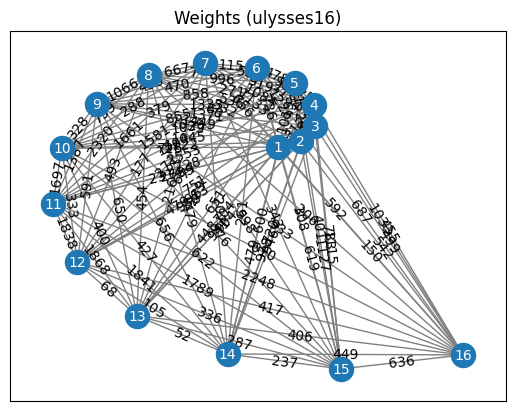

In [6]:
for problem_name, plot_data in plot_cache.items():
	plot_data.plot(plot_data.weights)
	plt.title(f'Weights ({problem_name})')
	plt.rcParams["figure.figsize"] = (PYPLOT_W, PYPLOT_H)
	plt.show()

Build features (and labels if enabled)

In [14]:
import optlearn.mst.mst_model
optlearn.mst.mst_model.use_paper_fg = USE_PAPER_FG

import optlearn.data.data_utils
optlearn.data.data_utils.build_labels = BUILD_LABELS

import numpy as np
np.set_printoptions(linewidth=np.inf)

from optlearn.experiments.build_data import build_features
proceed = True
if OVERRIDE_FEATURES:
	if input('Proceed to build features and labels? This will overwrite any redundant directories. (y/n) ').lower() != 'y':
		print('Aborted')
if proceed:
	build_features(
		NP_PATH,
		PROBLEMS_PATH,
		DESIRED_EDGE_FEATURES,
		override=OVERRIDE_FEATURES,
		solution_dir=SOLUTIONS_PATH
	)


Status:
Directory Status: Checked/Built


Iteration 1 of 4
Iteration 2 of 4
Iteration 3 of 4
Iteration 4 of 4
Building problem!
Setting variables!
Setting objective!
Setting constraints!
Constraints set!
Solving problem!
presolving:
   (0.0s) symmetry computation started: requiring (bin +, int +, cont +), (fixed: bin -, int -, cont -)
   (0.0s) no symmetry present (symcode time: 0.00)
presolving (1 rounds: 1 fast, 1 medium, 1 exhaustive):
 0 deleted vars, 0 deleted constraints, 0 added constraints, 0 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 0 implications, 0 cliques
presolved problem has 120 variables (0 bin, 0 int, 0 impl, 120 cont) and 16 constraints
     16 constraints of type <linear>
Presolving Time: 0.00

 time | node  | left  |LP iter|LP it/n|mem/heur|mdpt |vars |cons |rows |cuts |sepa|confs|strbr|  dualbound   | primalbound  |  gap   | compl. 
  0.0s|     1 |     0 |    24 |     - |  1372k |   0 | 120 |  16 |  16 |   0 |  0 |   0 |   0 | 6.1130

Load features (required for pretty-printing/plotting)

In [15]:
for problem_name, plot_data in plot_cache.items():
	plot_data.features_data = loader.load_features([
		os.path.join(NP_PATH, feature, problem_name + '.npy')
		for feature in DESIRED_EDGE_FEATURES])

Pretty-print features in a table (optional)

In [16]:
from tabulate import tabulate
for problem_name, plot_data in plot_cache.items():
	print(f'{problem_name}:')
	print(tabulate(
		plot_data.features_data,
		headers=DESIRED_EDGE_FEATURES,
		showindex=enumerate(plot_data.edges)
	))

ulysses16:
                        fa         fb         fc         fd         fe         ff        fg           fi           fj
---------------  ---------  ---------  ---------  ---------  ---------  ---------  --------  -----------  -----------
(0, (1, 2))      0.182796   0.220302   0.182796   0.103922   0.119608   0.24902    0.5       -0            0
(1, (1, 3))      0.179928   0.216847   0.18395    0.105578   0.121514   0.252988   0.333333  -0            0
(2, (1, 4))      0.112186   0.135205   0.122553   0.169329   0.194888   0.86901    0.5        0.0400517    0.0660774
(3, (1, 5))      0.365591   0.440605   0.667976   0.0519608  0.0598039  0.394118   0          0.31137      0.351319
(4, (1, 6))      0.264158   0.318359   0.465866   0.0719132  0.082768   0.157395   0          0.134367     0.33966
(5, (1, 7))      0.235484   0.283801   0.395307   0.0806697  0.0928463  0.17656    0          0.127907     0.277863
(6, (1, 8))      0.0218638  0.0263499  0.0262818  0.868852   1         

Plot features (optional)

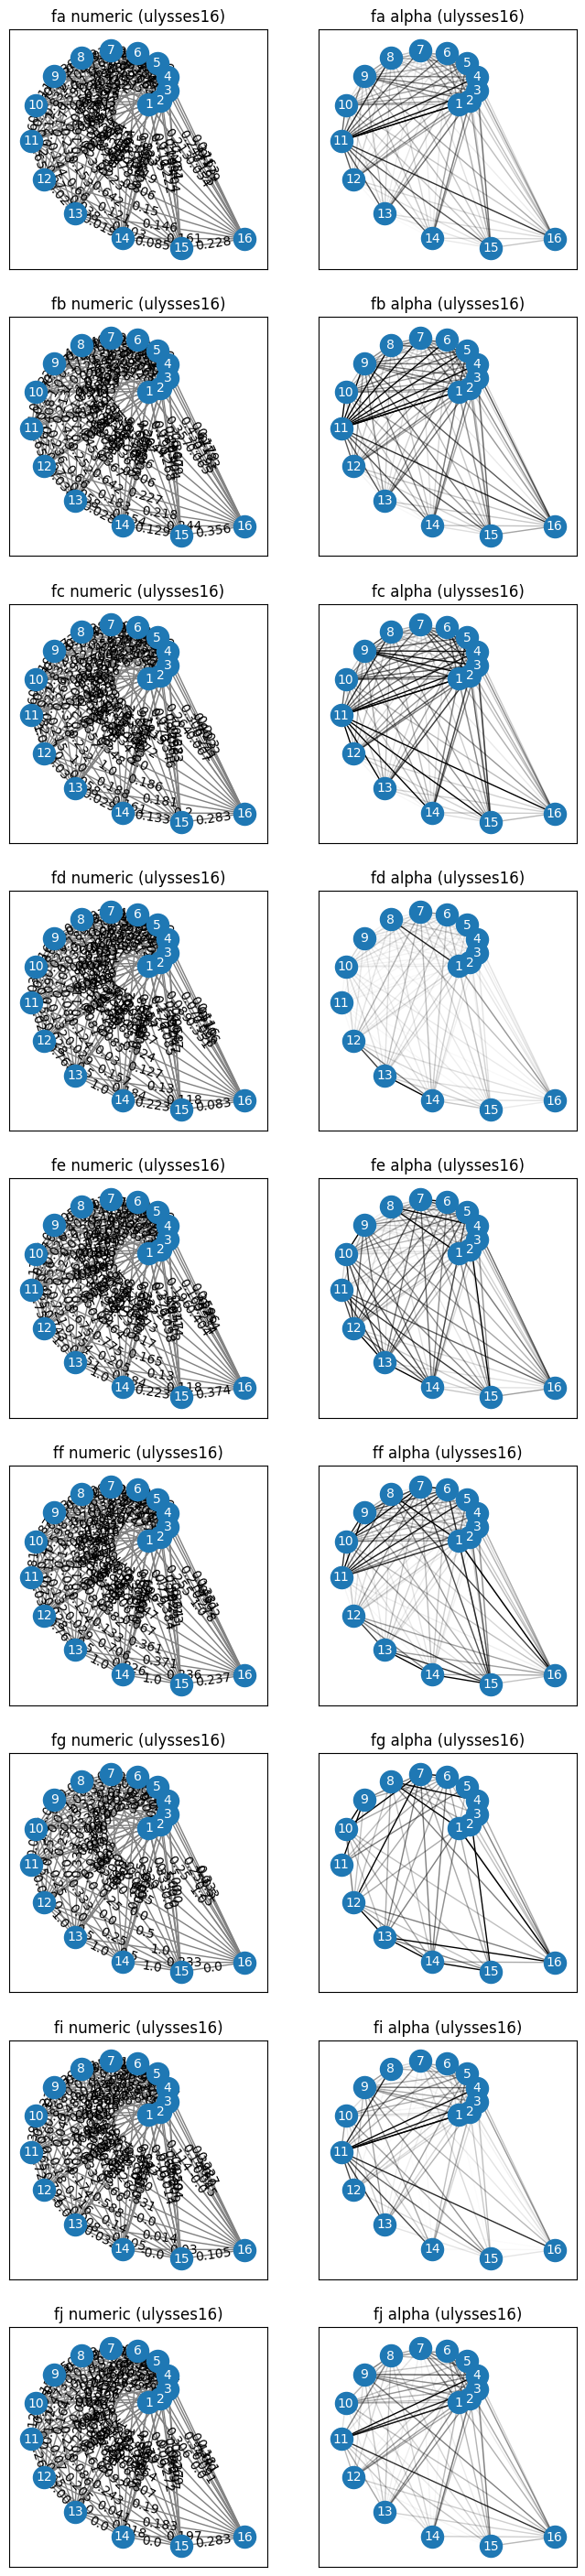

In [17]:
for problem_name, plot_data in plot_cache.items():
	# Based on
	# https://networkx.org/documentation/latest/auto_examples/drawing/plot_multigraphs.html#sphx-glr-auto-examples-drawing-plot-multigraphs-py
	fig, ax = plt.subplots(len(DESIRED_EDGE_FEATURES), 2)
	# Standardizes ax as a 2D list
	if len(DESIRED_EDGE_FEATURES) == 1:
		ax = [ax]

	for feature_idx, feature in enumerate(DESIRED_EDGE_FEATURES):
		ax_numeric: plt.Axes = ax[feature_idx][0]
		feature_data = plot_data.features_data[:,feature_idx]
		plot_data.plot(feature_data, ax=ax_numeric)
		ax_numeric.set_title(f'{feature} numeric ({problem_name})')

		ax_alpha: plt.Axes = ax[feature_idx][1]
		plot_data.plot(feature_data, ax=ax_alpha, use_alpha=True)
		ax_alpha.set_title(f'{feature} alpha ({problem_name})')
	
	fig.set_size_inches(PYPLOT_W * 2, PYPLOT_H * len(DESIRED_EDGE_FEATURES))
	plt.show()


Load and plot computed optimal solutions (optional)

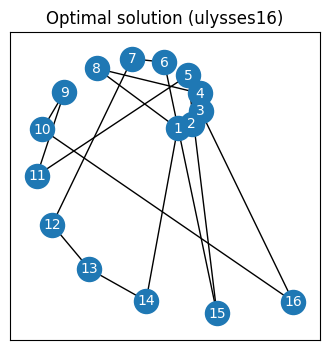

In [18]:
for problem_name, plot_data in plot_cache.items():
	plot_data.labels = loader.load_labels(
		os.path.join(NP_PATH, 'solutions', problem_name + '.npy'))
	plot_data.plot(plot_data.labels, use_alpha=True)
	plt.title(f'Optimal solution ({problem_name})')
	plt.rcParams["figure.figsize"] = (PYPLOT_W, PYPLOT_H)
	plt.show()